In [1]:
%matplotlib inline
# Common Imports
import numpy as np
#Pandas for creating dataframes
import pandas as pd
#Sklearn
from sklearn import preprocessing
#K-means clustering algo
from sklearn.cluster import KMeans
#OS moduled for file oprations
import os
#CSV module
import csv
#Plotting
import matplotlib.pyplot as plt

In [2]:
# Calculating Eigenvectors and eigenvalues of Cov matirx
def PCA_component_analysis(X_std):
    mean_vec = np.mean(X_std, axis=0)
    cov_mat = np.cov(X_std.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)

    # Create a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

    # # Sort from high to low
    eig_pairs.sort(key = lambda x: x[0], reverse= True)

    # Calculation of Explained Variance from the eigenvalues
    tot = sum(eig_vals)
    var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
    cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

    # PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
    plt.figure(figsize=(10, 5))
    plt.bar(range(9), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
    plt.step(range(9), cum_var_exp, where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.show()

In [3]:
from sklearn.decomposition import PCA
def draw_clusters(X, X_clusters, centroids, kmeans):
    #Use PCA component analysis for visuals
    if X.shape[1] > 2:
        reduced_X = PCA(n_components=2).fit_transform(X)
    else:
        reduced_X = X
   
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_X[:, 0].min() - 1, reduced_X[:, 0].max() + 1
    y_min, y_max = reduced_X[:, 1].min() - 1, reduced_X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')   
    #Plot the data points (PCA reduced components)
    plt.plot(reduced_X[:,0],reduced_X[:,1],  'k.', markersize=3) 
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
    plt.title('K-means clustering with (PCA-reduced data), Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [4]:
from scipy.spatial.distance import euclidean
#Calculate distance of data point from the its cluster center
def k_mean_dist(data, clusters, cluster_centers):
    distances = []
    for i, d in enumerate(data):
        center = cluster_centers[clusters[i]]
        distance = euclidean(d,center)
        #distance = np.linalg.norm(d - center)
        distances.append(distance)
    return distances

In [55]:
from sklearn.cluster import KMeans
#Find optimal number of clusters for k-means clustering using elbow method.
def elbow_method(X_trans):
    elbow_count = 0
    range_val = 10
    Nc = range(1, range_val)
    kmeans = [KMeans(n_clusters=i) for i in Nc]
    score = [kmeans[i].fit(X_trans).score(X_trans) for i in range(len(kmeans))]
    total_diff = abs(score[0] - score[len(score) -1])
    for i in range(range_val - 2):
        percent_diff = abs(score[i] - score[i+1])/total_diff
        if percent_diff < 0.01:
            elbow_count = i
            break
    plt.plot(Nc,score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.show()
    return elbow_count

In [6]:
import glob
#Merge sample files to create bigger sameple
def merge_sample_files(sample_folder, file_count):
    file_number = 1
    count = 0
    filenames = sorted(glob.glob(os.path.join(sample_folder,'*')),  key=os.path.getmtime)
    for filename in filenames:
        if count == 0:
            df = pd.read_csv(filename, index_col=0)
            count += 1
        else:
            temp_df = pd.read_csv(filename, index_col=0)
            df = df.append(temp_df)
            count += 1
        if count == file_count:
            df.to_csv(os.path.join(sample_folder,'m'+str(file_number)))
            df = df.drop(df.index, inplace=True)
            count = 0
            file_number +=1

In [7]:
def get_cluster_feature_vector_dict(cluster_folder):
    cluster_dict = dict()
    filenames = sorted(glob.glob(os.path.join(cluster_folder,'*')),  key=os.path.getmtime)
    first = True
    for filename in filenames:
        if first:
            df = pd.read_csv(filename, index_col=0)
            first = False
        else:
            temp_df = pd.read_csv(filename, index_col=0)
            df = df.append(temp_df) 
    df = df.reset_index().set_index(['cluster','ip'])
    clusters = df.index.get_level_values(0).unique()
    for c in clusters:
        cluster_dict[c] = df.loc[c].iloc[:,:-1].values
    return cluster_dict

In [8]:
def plot_outlier_detecton(X_train, clf):
    
    xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
    
    # plot the levels lines and the points
    print(clf.name)
    if clf.name == "lof":
        # decision_function is private for LOF
        Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    print(Z.max(), Z.min())
    plt.title("Novelty Detection")
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
    a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    #plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
    
    s = 40
    b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
    plt.axis('tight')
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([a.collections[0], b1],
           ["learned frontier", "training observations"],
           loc="upper left")
    plt.show()

In [9]:
#SKlearn SVM
from sklearn import svm
from sklearn.neighbors import LocalOutlierFactor
def one_class_svm_for_clusters(cluster_feature_dict):
    svm_dict = dict()
    scalar_dict = dict()
    for key, value in cluster_feature_dict.items():
        X_train = value
        #Get scaler
        scaler = preprocessing.StandardScaler().fit(X_train)
        scalar_dict[key] = scaler 
        #Transform Traning data
        X_trans = scaler.transform(X_train)
        # fit the model
        clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
        clf.fit(X_trans)
        clf.name = 'svm'
        plot_outlier_detecton(X_trans, clf)
        
        clf = LocalOutlierFactor(contamination=0.01)
        clf.fit(X_trans)
        clf.name= 'lof'
        plot_outlier_detecton(X_trans, clf)
        #Store trained SVM for each IP
        svm_dict[key] = clf
    return svm_dict, scalar_dict

In [10]:
#Base Folder sPaths
base_path = os.path.join('converted','test2')
#Normal
sample_path = os.path.join(base_path,'samples')
cluster_path = os.path.join(base_path,'ip_cluster')
#Attack
# sample_path = os.path.join(base_path,'attack_samples','1')
# cluster_path = os.path.join(base_path,'attack_ip_cluster','1')

centroid_path = os.path.join(base_path,'centroids')

In [59]:
#merge_sample_files(sample_path,3)
d = get_cluster_feature_vector_dict(cluster_path)

In [77]:
#svm_dict, scaler_dict = one_class_svm_for_clusters(d)

In [27]:
svm_dict

{0: OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
       max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
       verbose=False),
 1: OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
       max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
       verbose=False),
 2: OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
       max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
       verbose=False)}

In [50]:
#Predict for the give destination if it is normal or not
X_test = [[0,120]]
X_test_tran = scaler_dict[0].transform(X_test)
svm_dict[0].predict(X_test_tran)

array([-1])

In [64]:
def create_feature_dataframe(sample_file, features):
        df = pd.read_csv(sample_file, index_col=0)
        #Filter Columns
        df = df[['ip.dst', 'ip.proto', 'sniff_timestamp', 'sample']]
        #Remove null destinations
        df = df[df['ip.dst'].notnull()]
        #Rename Columns
        df.columns = ['ip', 'protocol', 'time_stamp', 'sample']
        #Get count for each ip
        df = df.groupby(['ip', 'protocol']).size().unstack().fillna(0).astype(int)
        #Select TCP and UDP as only fetures (TCP:6, UDP:17)
        df = df[features]
        return df    

In [62]:
#Create feature dataframes from the sample files
def get_all_dataframes(sample_path, features):
    sample_df_list = []
    for filename in os.listdir(sample_path):
        sample_file = os.path.join(sample_path,filename)
        df = create_feature_dataframe(sample_file, features)
        sample_df_list.append(df)
    return sample_df_list    

In [70]:
def get_kmeans_centroid(feature_df, cluster_count):
    """ X -> feature vector 
        cluster_count -> Number of clusters to be used for k-means
    """
    df_centroid = {}
    X = feature_df.values
    #Create scaling
    scaler = preprocessing.StandardScaler().fit(X)
    #Transform Traning data
    X_trans = scaler.transform(X)
    #Data Fitting using K-means
    kmeans = KMeans(n_clusters=cluster_count)
    kmeans.fit(X_trans)
    #Insert cluster center to its corrosposnding dataframe each dataframe.
    #Dataframe 0 contain all the clusters centers associated with 0th cluster
    first = True
    for i in range(kmeans.cluster_centers_.shape[0]):
        s = pd.Series(kmeans.cluster_centers_[i], index=feature_df.columns)
        if(first):
            df_centroid = pd.DataFrame(columns=feature_df.columns)
            first = False
        df_centroid = df_centroid.append(s,ignore_index=True)
    return df_centroid

In [72]:
first = True
ip_dict = dict()
sample_count = 1;
centroid_dfs = []
first = True
cluster_count = 3
features = [6,17] #(TCP:6, UDP:17)


sample_df_list = get_all_dataframes(sample_path, features)

protocol        6         17
0        -0.166345 -0.127190
1         7.076639  7.264017
2         2.072327 -0.268560


/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [151]:
df_concat = pd.DataFrame(columns=sample_df_list[0].columns)
for df in sample_df_list:
    df_centroid = get_kmeans_centroid(df, cluster_count)
    df_concat = df_concat.append(df_centroid)

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [191]:
clusters = df_concat.index.unique()
centroids = []
print(centroid)
for c in clusters:
    med = np.median(df_concat.loc[c], axis=0)
    centroids.append(med)
centroids

Empty DataFrame
Columns: [6, 17]
Index: []


[array([-0.15796935, -0.16722516]),
 array([ 5.70622974,  5.58412517]),
 array([ 1.43205544, -0.12828593])]

In [152]:
df_concat.head()

protocol,6,17
0,-0.166345,-0.127190
1,7.076639,7.264017
2,2.072327,-0.268560
0,-0.220529,-0.156230
1,5.349025,5.816018


In [168]:
df = df_concat
#df = df.sort_index()
df = df.loc[0]
df.head()

protocol,6,17
0,-0.166345,-0.127190
0,-0.220529,-0.156230
0,6.090036,5.875205
0,-0.200142,-0.152828
0,-0.354126,0.544505


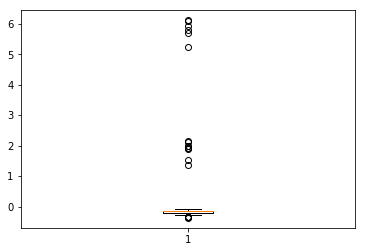

In [177]:
r = plt.boxplot(df[6])

In [176]:
np.median(df, axis=0)

array([-0.15796935, -0.16722516])

In [175]:
r["fliers"][0].get_data()

(array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 array([-0.34233056, -0.34379134, -0.34593079, -0.37158622, -0.34250916,
        -0.32285204, -0.34742336, -0.3585919 ,  5.87520501,  0.54450508,
         0.32278263,  4.83211222,  5.68956244,  6.23478657,  1.4282741 ,
         3.56862271,  0.29162963,  5.88973673,  0.39332082,  5.08139928,
         4.34111223,  4.98506756]))

In [190]:
# mean = df.mean()
# print(mean)
# std = df.std()
# print(3*std)
# print("****")
# df[np.abs(df - mean) <= 3*std]
# for index, row in df.iterrows():
#     if (np.abs(row - mean) > 3*std).any():
#         print("outlier")
#         print(row)

In [119]:
from scipy import stats
a = [1,1,10,20,15,18]
b = stats.trimboth(a, 0.1)
b

array([ 1, 15,  1, 10, 18, 20])

In [33]:
#Calculate Centroid Mean
centroids = []
features = set()
for df in centroid_dfs:
    centroid = []
    for c in df.columns:
        df = df[np.abs(df[c] - df[c].mean()) <= (3*df[c].std())]
        #print(df[c])
        centroid.append(df[c].mean())
    centroids.append(centroid)
    features |= set(df.columns)
#Save centroid for future clusterinng
if not os.path.exists(centroid_path):
    os.makedirs(centroid_path)
np.savetxt(centroid_path+"centroids.csv", np.asarray(centroids), delimiter=",")
np.savetxt(centroid_path+"features.csv", np.asarray(list(features)), delimiter=",")

In [44]:
#Actual Clustering

#Get centroid created in initial step
centroids = np.genfromtxt(centroid_path+"centroids.csv", delimiter=',')
features = np.genfromtxt(centroid_path+"features.csv", delimiter=',')
sample_count = 1
for filename in os.listdir(sample_path):
    tdf = pd.read_csv(sample_path+filename, index_col=0)
    #Filter Columns
    t = tdf[['ip.dst', 'ip.proto', 'sniff_timestamp', 'sample']]
    #Remove null destinations
    t = t[t['ip.dst'].notnull()]
    #Rename Columns
    t.columns = ['ip', 'proto', 'time_stamp', 'sample']
    #Get count for each ip
    df = t.groupby(['ip', 'proto']).size().unstack().fillna(0).astype(int)
    #Select TCP and UDP as only fetures (TCP:6, UDP:17)
    df = df[[6,17]]
    if(set(df.columns) != set(features)):
        print(df.columns, features)
        non_columns = set(features) - set(df.columns)
        for c in non_columns:
            df.insert(loc=1, column=c, value=0)
    #Get value matrix
    X = df.values
    #Create scaling
    scaler = preprocessing.StandardScaler().fit(X)
    #Transform Traning data
    X_trans = scaler.transform(X)
    #Data Fitting using K-means
    kmeans = KMeans(n_clusters=centroids.shape[0], init=centroids)
    clusters = kmeans.fit_predict(X_trans)
    #Plot clusters and data using PCA component analysis
    #draw_clusters(X_trans, clusters, centroids, kmeans)
    distances = k_mean_dist(X_trans, clusters, centroids)
    #Attaching label/cluster to IP
    cluster_df = pd.DataFrame({'cluster': kmeans.labels_})
    #Attaching distance from the cluster for each data point
    distance_df = pd.DataFrame({'distance': distances})
    ip_label_df = pd.concat([df.reset_index(), cluster_df, distance_df], axis=1).set_index('ip')
    if not os.path.exists(cluster_path):
        os.makedirs(cluster_path)
    ip_label_df.to_csv(cluster_path+str(sample_count))
    sample_count += 1

C:\Users\Tuli\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Tuli\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [95]:
#For a given IP address find how many time a given cluster it was assigned to.
from itertools import groupby
def get_IP_cluster_count_dict(cluster_path):    
    ip_dict = dict()
    filenames = glob.glob(os.path.join(cluster_path,'*'))
    for filename in filenames:
        with open(filename, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if row['ip'] in ip_dict:
                    #print(row['ip'],ip_dict[row['ip']])
                    ip_dict[row['ip']] = ip_dict[row['ip']] + [row['cluster']]
                else:
                    ip_dict[row['ip']] = [row['cluster']]
    #Find how many time IP was assigned to a given cluster
    ip_cluster_dict = dict()
    for key, value in ip_dict.items():
        ip_cluster_dict[key] = {k: len(list(group)) for k, group in groupby(value)}
    return ip_cluster_dict

In [96]:
ip_cluster_dict = get_IP_cluster_count_dict(cluster_path)

In [77]:
#ip_cluster_dict

In [157]:
df = pd.DataFrame([np.arange(5)]*3)

In [17]:
vals = [-114.0, -9.3187241903579459, -4.3769387148407386, -1.8276073696951562,
        -1.111777920816883, -0.73454965159430574, -0.50130043613458697, -0.32255237503735512, -0.23209280297904877]


In [42]:
for i in range(1,10):
    print(i)

1
2
3
4
5
6
7
8
9


In [19]:
len(vals)

9

In [24]:
total_diff = abs(vals[0] - vals[8])

In [36]:
elbow_val = []
for i in range(8):
    diff = abs(vals[i] - vals[i+1])/ total_diff
    if diff < 0.01:
        elbow_val.append(i)
        print(diff)
        break

print(elbow_val)        

0.006292015617713829
[3]


In [37]:
elbow_val = [3,4,3,3,3,4,4,4,3,3,3,3,3,3,3]

In [39]:
np.floor(np.mean(elbow_val))

3.0